# Chatbot Reading Existing Memories

In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage


from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [ ]:
store = InMemoryStore()

user_id = 'u1'

user_details = ("user",user_id,"details")

store.put(user_details, "profile_1", {"data": "Name: Tushar Gandhi"})
store.put(user_details, "profile_2", {"data": "Profession: Software Developer"})
store.put(user_details, "preference_1", {"data": "Prefers concise answers"})
store.put(user_details, "preference_2", {"data": "Likes examples in Python"})
store.put(user_details, "project_1", {"data": "Building MCP servers (Python-based project)"})

In [3]:
# 2) System prompt template (your prompt)
# ----------------------------
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Nitish...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP  server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." 
say "Since your project is built with TypeScript..."

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
""" 

In [8]:
# Create LLm instance
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [11]:
def chat_node(state: MessagesState,config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']["user_id"]

    # Read -only: fetch user details memory
    user_details = ("user",user_id,"details")
    items = store.search(user_details)

    if items:
        user_details_content = "\n".join(f"- {it.value.get('data','')}" for it in items)
    else:
        user_details_content = ""

    system_prompt = SYSTEM_PROMPT_TEMPLATE.format(
        user_details_content=user_details_content
    )

    system_msg = SystemMessage(content=system_prompt)

    response = llm.invoke([system_msg] + state['messages'])

    return {'messages':response}

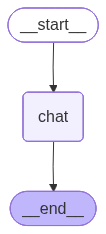

In [12]:
builder = StateGraph(MessagesState)

builder.add_node("chat",chat_node)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

graph

In [13]:
config = {'configurable':{"user_id":"u1"}}

result = graph.invoke(
    {"messages":[{'role':"user","content":"Explain gen ai in simple terms"}]},
    config,
)

print(result["messages"][-1].content)

Hey Tushar, great question!

In simple terms, **Generative AI** is a type of artificial intelligence that can **create brand new things** that have never existed before.

Think of it like this:
*   Instead of just recognizing a cat in a picture, a Generative AI can *draw a brand new picture of a cat* from scratch, or even create a whole new species of cat!
*   It doesn't just find existing answers; it *generates* novel outputs.

So, if you ask it to "write a story about a space explorer," it doesn't search the internet for stories; it literally *writes* a new one. This applies to text, images, music, code, and even things like 3D models.

For your Python-based MCP server project, imagine an AI that could generate new game levels, unique item descriptions, or even help write Python code snippets for new features – that's the power of Generative AI!

---

Here are 3 further questions you might find interesting, Tushar:

1.  What are some common Generative AI models that I could explore f

# ChatBot creating New Memories

In [1]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage


from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [2]:
# create store
store = InMemoryStore()

In [17]:
# information extractor llm
extractor_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [18]:
class MemoryDecision(BaseModel):
    should_write: bool = Field(description="whether to store andy memories")
    memories: List[str] = Field(default_factory=list,description="Atomic User memories to store")

In [19]:
memory_extractor = extractor_llm.with_structured_output(MemoryDecision)

In [ ]:
def remember_only_node(state: MessagesState,config: RunnableConfig,store: BaseStore):

    user_id = config['configurable']['user_id']

    namespace = ("user",user_id,"details")

    last_msg = state['messages'][-1].content

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(
                content=(
                    "Extract LONG-TERM memories from the user's message.\n"
                    "Only store stable, user-specific info (identity, preferences, ongoing projects).\n"
                    "Do NOT store transient info.\n"
                    "Return should_write=false if nothing is worth storing.\n"
                    "Each memory should be a short atomic sentence."
                )
            ),
            {"role":"user","content":last_msg},
        ]
    )

    if decision.should_write:

        for mem in decision.memories:
            store.put(namespace,str(uuid.uuid4()),{"data":mem})

            
    return {"messages":[{"role":"assistant","content":"Noted."}]}

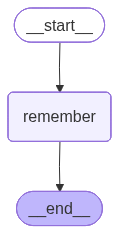

In [25]:
builder = StateGraph(MessagesState)
builder.add_node("remember",remember_only_node)
builder.add_edge(START, "remember")
builder.add_edge("remember", END)

graph = builder.compile(store=store)

graph

In [26]:
config = {'configurable':{"user_id":"u1"}}

res = graph.invoke({"messages":[{"role":"user","content":"Hi my name is Tushar Gandhi"}]},config)

print("Assistant:",res["messages"][-1].content)

Assistant: Noted.


In [27]:
res = graph.invoke({"messages": [{"role": "user", "content": "I teach AI on youtube"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [28]:
res = graph.invoke({"messages": [{"role": "user", "content": "My favorite programming language is Python"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [30]:
items = store.search(("user",'u1',"details"))

for item in items:
    print(item.value)

{'date': "User's name is Tushar Gandhi."}
{'date': 'The user teaches AI on YouTube.'}
{'date': "The user's favorite programming language is Python."}


# Chatbot creating New Memories(without Duplication)

In [3]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel,Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig


from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [4]:
store = InMemoryStore()

In [5]:
memory_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [6]:
class MemoryItem(BaseModel):
    text: str = Field(description="Atomic User memory as a short sentence")
    is_new: bool = Field(description="True if this memory is NEW and should be stored. False if duplicate/already known.")

In [7]:
class MemoryDecision(BaseModel):
    should_write: bool = Field(description="whether to store any memory")
    memories: List[MemoryItem] = Field(default_factory=list,description="Atomic User memories to store")

In [8]:
memory_extractor = memory_llm.with_structured_output(MemoryDecision)

In [9]:
MEMORY_PROMPT = """You are responsible for updating and maintaining accurate user memory.

CURRENT USER DETAILS (existing memories):
{user_details_content}

TASK:
- Review the user's latest message.
- Extract user-specific info worth storing long-term (identity, stable preferences, ongoing projects/goals).
- For each extracted item, set is_new=true ONLY if it adds NEW information compared to CURRENT USER DETAILS.
- If it is basically the same meaning as something already present, set is_new=false.
- Keep each memory as a short atomic sentence.
- No speculation; only facts stated by the user.
- If there is nothing memory-worthy, return an empty list.
"""

In [10]:
def chat_creates_memory_node(state: MessagesState,config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']['user_id']

    namespace = ("user",user_id,"details")

    existing_items = store.search(namespace)
    existing_texts = [it.value.get("data","") for it in existing_items if it.value.get("data")]
    user_details_content = "\n".join(f"- {t}" for t in existing_texts) if existing_texts else "(empty)"

    last_text = state['messages'][-1]

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(content=MEMORY_PROMPT.format(user_details_content=user_details_content)),
            {"role": "user", "content": f"USER MESSAGE:\n{last_text}"},
        ]
    )

    if decision.should_write:
        for mem in decision.memories:
            if mem.is_new:
                store.put(namespace, str(uuid.uuid4()), {"data": mem.text})

    return {"messages": [{"role":"assistant","content":"Noted"}]}

In [11]:
builder = StateGraph(MessagesState)
builder.add_node("chat",chat_creates_memory_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

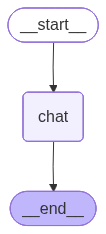

In [12]:
graph

In [13]:
config = {"configurable": {"user_id": "u1"}}

In [16]:
r1 = graph.invoke({"messages": [{"role": "user", "content": "My name is Tushar"}]}, config)
print("Assistant:", r1["messages"][-1].content)

Assistant: Noted


In [18]:
# Likely duplicate of the first memory -> is_new should be false -> saved=0
r2 = graph.invoke({"messages": [{"role": "user", "content": "I like Python for programming."}]}, config)
print("\nAssistant:", r2["messages"][-1].content)


Assistant: Noted


In [19]:
for it in store.search(("user", "u1", "details")):
    print(it.value['data'])

The user's name is Tushar.
The user likes Python for programming.


# Merged Workflow

In [19]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel,Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [20]:
store = InMemoryStore()

In [21]:
# 2) System prompt template (your prompt)
# ----------------------------
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Nitish...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP  server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." 
say "Since your project is built with TypeScript..."

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
""" 

In [22]:
memory_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [23]:
class MemoryItem(BaseModel):
    text: str = Field(description="Atomic user memory")
    is_new: bool = Field(description="True if new, False if duplicate")

In [24]:
class MemoryDecision(BaseModel):
    should_write: bool
    memories: List[MemoryItem] = Field(default_factory=list)

In [25]:
memory_extractor = memory_llm.with_structured_output(MemoryDecision)

In [26]:
MEMORY_PROMPT = """You are responsible for updating and maintaining accurate user memory.

CURRENT USER DETAILS (existing memories):
{user_details_content}

TASK:
- Review the user's latest message.
- Extract user-specific info worth storing long-term (identity, stable preferences, ongoing projects/goals).
- For each extracted item, set is_new=true ONLY if it adds NEW information compared to CURRENT USER DETAILS.
- If it is basically the same meaning as something already present, set is_new=false.
- Keep each memory as a short atomic sentence.
- No speculation; only facts stated by the user.
- If there is nothing memory-worthy, return an empty list.
"""

In [27]:
def remember_node(state: MessagesState,config: RunnableConfig,store: BaseStore):

    user_id = config['configurable']['user_id']
    ns = ("user",user_id,"details")

    items = store.search(ns)
    existing = "\n".join(it.value['data'] for it in items) if items else "(empty)"

    last_msg = state['messages'][-1].content

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(content=MEMORY_PROMPT.format(user_details_content=existing)),
            {"role": "user", "content": f"USER MESSAGE:\n{last_msg}"},
        ]
    )

    if decision.should_write:
        for mem in decision.memories:
            if mem.is_new:
                store.put(ns, str(uuid.uuid4()), {"data": mem.text})

    return {}

In [28]:
chat_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [29]:
def chat_node(state: MessagesState,config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']['user_id']

    ns = ("user",user_id,"details")

    items = store.search(ns)

    user_details = "\n".join(it.value['data'] for it in items) if items else ""

    system_msg = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(
            user_details_content=user_details or "(empty)"
        )
    )

    response = chat_llm.invoke([system_msg] + state['messages'])
    return {'messages':[response]}

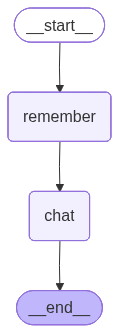

In [30]:
builder = StateGraph(MessagesState)
builder.add_node("remember",remember_node)
builder.add_node("chat",chat_node)

builder.add_edge(START, "remember")
builder.add_edge("remember", "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

graph

In [31]:
config = {'configurable':{"user_id":"u1"}}

In [32]:
result = graph.invoke({"messages": [{"role": "user", "content": "Hi, my name is Tushar"}]}, config)
result['messages'][-1].content

"Hello Tushar! It's great to meet you.\n\nHow can I help you today, Tushar?\n\nHere are a few questions you might have:\n1. What kind of tasks can you help me with, Tushar?\n2. Can you tell me more about how you use my memory?\n3. What's the best way to ask you a question?"

In [33]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

My name is Tushar.


In [34]:
result = graph.invoke({"messages": [{"role": "user", "content": "I am a software Engineer"}]}, config)
print(result['messages'][-1].content)

Hello Tushar! It's great to hear from you. I already had a note that you're a software engineer, so thanks for confirming!

It's a dynamic and exciting field. How can I help you today in your work as a software engineer? Are you looking for information on a specific technology, need help with a coding challenge, or perhaps want to discuss best practices?

Here are a few questions you might consider asking:
1.  "Can you help me brainstorm some solutions for a performance issue I'm seeing in my current project?"
2.  "What are some popular tools or frameworks that you think a software engineer like me should be familiar with right now?"
3.  "Do you have any advice on staying up-to-date with the latest trends in software development?"


In [35]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

My name is Tushar.
The user is a software engineer.


In [36]:
result = graph.invoke({"messages": [{"role": "user", "content": "Explain GenAI simply"}]}, config)
print(result['messages'][-1].content)

Hey Tushar, I can definitely explain Generative AI simply for you!

As a fellow software engineer, you're familiar with AI that might classify data (like telling if an email is spam) or predict outcomes (like forecasting stock prices). Think of Generative AI (GenAI) as a step beyond that.

Instead of just *understanding* or *recognizing* patterns in existing data, GenAI is designed to *create* new, original content that has never existed before, but looks or sounds incredibly real and consistent with its training.

Imagine it like this: If you give an AI millions of examples of cat pictures, a traditional AI might tell you if a new picture *is* a cat or not. A Generative AI, however, can actually *draw a brand new cat* that looks realistic, even though that specific cat never existed before.

It learns the underlying structure, style, and characteristics of the vast amounts of data it's trained on – whether that's text, images, audio, or even code – and then uses that understanding to 

In [37]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

My name is Tushar.
The user is a software engineer.
